### Time-longitude hovmuller plots of monthly SIA, SST and depth-averaged ocean T and S

In [2]:
#set up: import packages 
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cf_xarray as cf
import pandas as pd
import cmocean as cm


from dask.distributed import Client
Client=Client()

## Inputs

In [76]:
#spatial domain (for ocean data_
latmax = -55. ; latmin = -65. 
zmin = 50. ; zmax = 200.

#climatology period
clst = 2004 ; clen = 2018 

diri = '/g/data/jk72/wrh581/'

#sea ice data
fice = [diri+'NSIDC/NSIDC_SH_icearea_v05r00_197811-202406.nc',
    diri+'NSIDC/NSIDC_SH_icearea_v03r00_202407-202412.nc']
icevar = 'SIA'

#SST
fsst = diri+'OISST/OIv2_SST_1982-2024.nc'
sstNam = 'sst'

# sub-surface ocean
src  = 'EN4'
prefix = src+'/EN.4.2.2.?.analysis.l09.'
sNam = 'salinity' ; tNam = 'temperature'   #variable names


#output filepath
dirp = diri+'Obs-seaice-analysis/plots/'
filp = 'SIA-ocean_anoms_lontime_hovmuller.png'

## Read ice SIA

In [57]:
idata = xr.open_mfdataset(fice, parallel = True)

#add a datetime ime-coord
yrst = int(idata.time[0]/100) ; mst = int(idata.time[0]%100) -1
yren = int(idata.time.max()/100) ; men = int(idata.time.max()%100) 
newtime = pd.date_range(start=f'{yrst}-{mst:02d}-15', end=f'{yren}-{men:02d}-15', freq='MS')  + pd.DateOffset(days=14)
idata = idata.assign_coords(time = newtime)


#smooth lon
box_size = max([1, int(len(idata.cf['longitude'])/360) ])
idata = idata.coarsen({idata.cf['longitude'].name : box_size} ).mean()

#get anom
climsel = {'time' : slice(str(clst), str(clen)) }
ice = idata[icevar].groupby('time.month') - idata[icevar].sel(**climsel).groupby('time.month').mean('time')
                                                          
if idata[icevar].units == 'km**2': # change units to thousand km2 if required
    ice = ice * 1.e-3

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


## Read SST

In [6]:
sstdata = xr.open_dataset(fsst)

#lat/lon mean

sst = sstdata[sstNam].cf.sel(latitude = slice(latmin, latmax))
sst = sst.weighted(np.cos(np.deg2rad(sst.cf['latitude']))).mean(sstdata.cf['latitude'].name)

box_size = max([1, int(len(sstdata.cf['longitude'])/360) ])
sst = sst.coarsen({sstdata.cf['longitude'].name : box_size} ).mean()


#anomaly
sst = sst.groupby('time.month') - sst.sel( **climsel).groupby('time.month').mean('time')


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


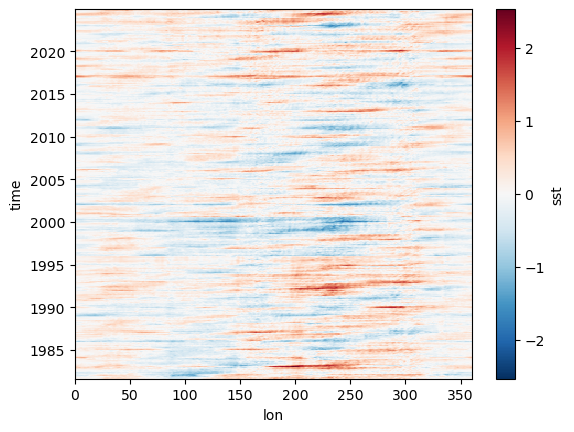

In [7]:
sst.plot()

## Read subsurface T/S

In [39]:
#get file list for all years and months in range
cmd = 'ls '+diri+prefix+'*.nc'  #unix command
fpath = !$cmd
odata = xr.open_mfdataset(fpath, parallel=True)

odata =odata.cf.sel(**{ 'vertical' : slice(zmin, zmax), 'latitude' : slice(latmin, latmax)})

#smooth lon
box_size = max([1, int(len(odata.cf['longitude'])/360) ])
odata = odata.coarsen({odata.cf['longitude'].name : box_size} ).mean()


# #depth/lat weight average anoms
zNam = odata.cf['vertical'].name ; yNam = odata.cf['latitude'].name 
wgty = xr.DataArray(np.cos(np.deg2rad(odata[yNam].values)), dims=yNam, coords={yNam: odata[yNam]})
wgtz = xr.DataArray(odata["depth_bnds"][0,:, 1] - odata["depth_bnds"][0,:, 0], dims=[zNam], coords={zNam: odata[zNam]})
wgt  = wgtz * wgty

for var in [tNam, sNam]:
    odata[var] = odata[var].weighted( wgtz * wgty).mean(dim=(zNam, yNam )) 
    odata[var] = odata[var].groupby('time.month') - odata[var].sel(**climsel).groupby('time.month').mean('time')



odata


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_m

<xarray.Dataset> Size: 240MB
Dimensions:                          (time: 228, lon: 360, depth: 11, lat: 11,
                                      bnds: 2)
Coordinates:
  * depth                            (depth) float32 44B 55.69 66.04 ... 184.7
  * lat                              (lat) float32 44B -65.0 -64.0 ... -55.0
  * lon                              (lon) float32 1kB 1.0 2.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 2kB 2006-01-16T12:...
    month                            (time) int64 2kB 1 2 3 4 5 ... 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    temperature                      (time, lon) float64 657kB dask.array<chunksize=(1, 180), meta=np.ndarray>
    salinity                         (time, lon) float64 657kB dask.array<chunksize=(1, 180), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float64 79MB dask.array<chunksize=(1, 11, 11, 180), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float64 79MB dask.array<chunksize=(1, 11, 11, 180), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 40MB dask.array<chunksize=(1, 11, 11, 180), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 40MB dask.array<chunksize=(1, 11, 11, 180), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] 4kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    depth_bnds                       (time, depth, bnds) float32 20kB dask.array<chunksize=(1, 11, 2), meta=np.ndarray>
Attributes: (12/22)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    institution:            UK Met Office
    contact:                Rachel Killick - rachel.killick@metoffice.gov.uk
    ...                     ...
    southernmost_latitude:  -90.5
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...

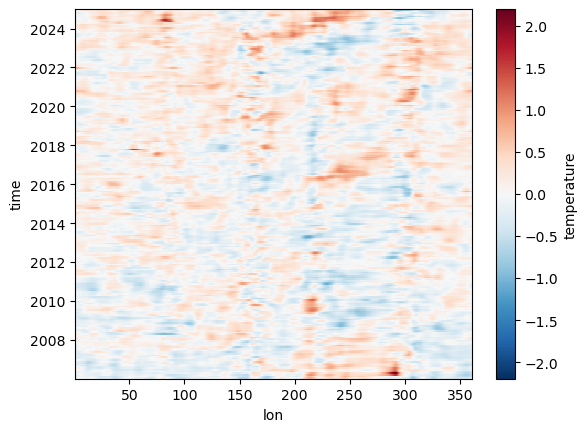

In [40]:
odata[tNam].plot()

In [46]:
ice = ice.compute()
sst = sst.compute()
odata = odata.compute()

## plot

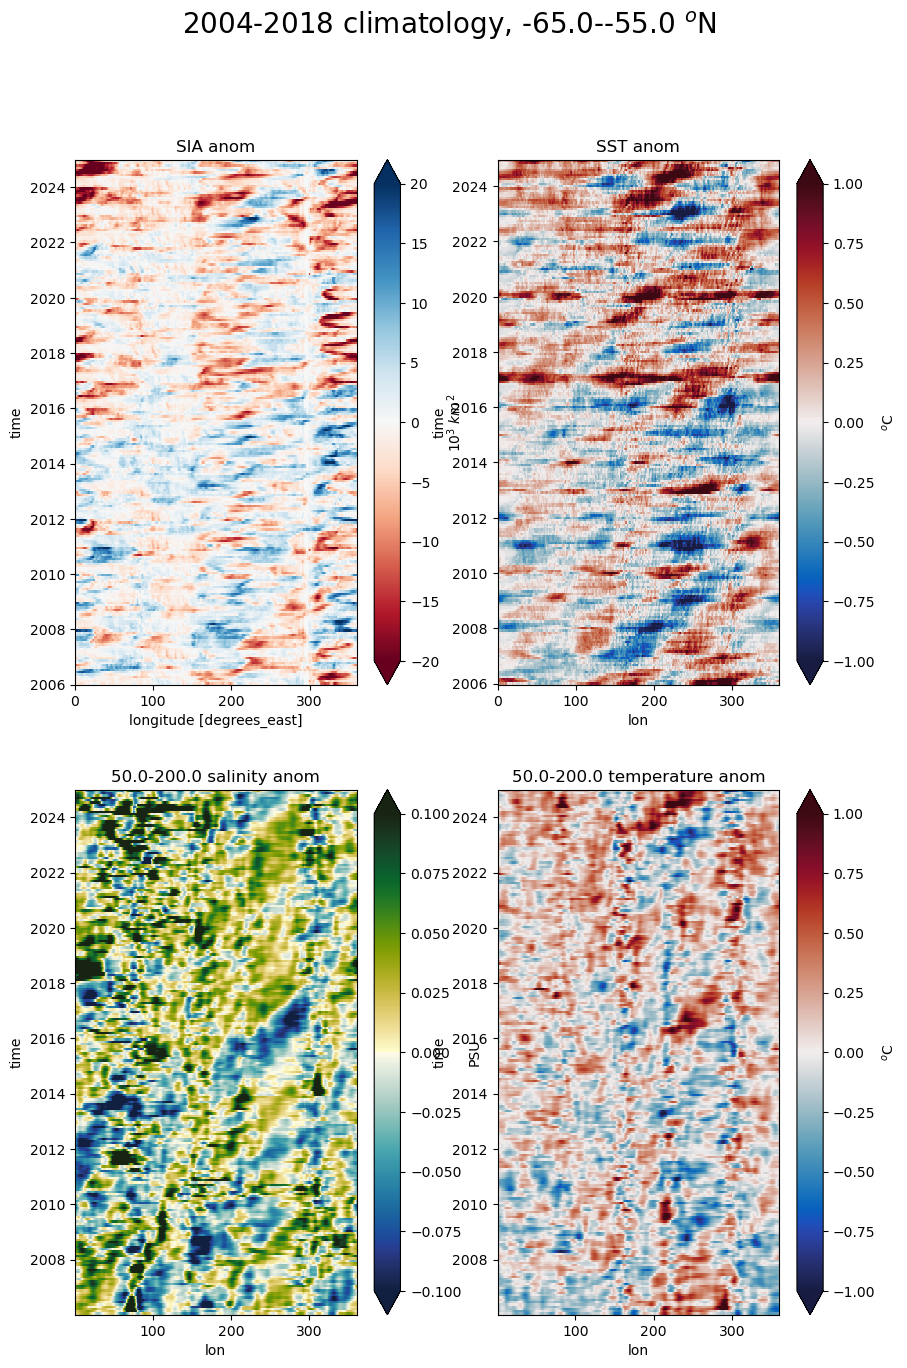

In [77]:
plt.figure(figsize = (10,15))

tsel = {'time' : slice('2006', '2024')}

nrow = 2 ; ncol = 2

plt.subplot(nrow, ncol,1)
cmax = 20
ice.sel(**tsel).plot(vmin = -cmax, vmax = cmax,  cmap = 'RdBu', cbar_kwargs={'label' : '$10^3$ $km^2$'})
plt.title(icevar+' anom')

plt.subplot(nrow, ncol,2)
cmax = 1.
sst.sel(**tsel).plot(vmin = -cmax, vmax = cmax, cmap = cm.cm.balance, cbar_kwargs={'label' : '$^o$C'})
plt.title('SST anom')

plt.subplot(nrow, ncol,4)
odata[tNam].sel(**tsel).plot(vmin = -cmax, vmax = cmax,cmap = cm.cm.balance, cbar_kwargs={'label' : '$^o$C'})
plt.title(str(zmin)+'-'+str(zmax)+' '+tNam+' anom')

plt.subplot(nrow, ncol,3)
cmax = .1
odata[sNam].sel(**tsel).plot(vmin = -cmax, vmax = cmax, cmap = cm.cm.delta, cbar_kwargs={'label' : 'PSU'})
plt.title(str(zmin)+'-'+str(zmax)+' '+sNam+' anom')

#plt.tight_layout()
plt.suptitle(str(clst)+'-'+str(clen)+' climatology, '+str(latmin)+'-'+str(latmax)+' $^o$N', fontsize=20)

plt.savefig(dirp+filp, bbox_inches='tight')

In [79]:
Client.close()